In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
import os 
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

np.random.seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath = "drive/My Drive/Documents/Education/University - 1 - UVA/Coursework - 6 - 2020 Fall/CS 4774 Machine Learning/ML4VA Project/ml4va"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import data
df0 = pd.read_csv(filepath + "/Virginia_Crashes.csv")
df0.head()

,X,Y,OBJECTID,Document_Nbr,Crash_Dt,Time_Slicing,Weather_Condition,Rte_Nm,Rns_Mp,First_Harmful_Event_of_Entire_C,Speed_Notspeed,Belted_Unbelted,Alcohol_Notalcohol,Rd_Type,Collision_Type,Vehicle_Body_Type_Cd,Driver_Action_Type_Cd,Crash_Severity,K_People,A_People,B_People,C_People,LATITUDE,LONGITUDE,VSP,SYSTEM,OWNERSHIP,CRASH_YEAR,Local_Case_Cd,FAC,FUN,Light_Condition,DIAGRAM,VDOT_District,Node_Info,Ownership_Used,Physical_Juris,Plan_District,Carspeedlimit,Crash_Military_Tm,Crash_Event_Type_Dsc,Rte_Category_Cd,Roadway_Surface_Cond,Vehiclenumber,Driverage,Drivergen,Driverinjurytype,Passage,Pedage,Pedgen,Pedinjurytype,Passgen,Passinjurytype
0,-76.699480,36.827038,1,130015005,2013/01/02 00:00:00+00,6PM TO 9PM,1. No Adverse Condition (Clear/Cloudy),R-VA046SC00606EB,3.840718,14. Ditch,Not_SPEED,BELTED,Not_ALCOHOL,RD-UNKNOWN,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,B.Visible Injury,0,0,1,0,36.827030,-76.699478,5,3,3,2013,201202934,"0.Two-way, non-divided",6.Rural Local,4. Darkness - Road Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,5.Hampton Roads,393039.Deer Path Trl; SC-606E (Isle of Wight C...,VDOT_SEC,46.Isle of Wight,23.Hampton Roads,NaN,2007,14. Ditch,SEC,1. Dry,1,18,Female,B,NaN,NaN,NaN,NaN,NaN,NaN
1,-77.663366,37.609240,2,130015012,2013/01/02 00:00:00+00,0AM TO 3AM,1. No Adverse Condition (Clear/Cloudy),R-VA SR00288NB,28.361159,23. Animal,Not_SPEED,BELTED,Not_ALCOHOL,NOT-RD,10. Deer,22. Truck - Sport Utility Vehicle (SUV),1. No Improper Action,C.Nonvisible Injury,0,0,0,1,37.609232,-77.663364,1,2,2,2013,DIV113000009,"3.Divided, full control of access",7.Rural Principal Arterial - Other Freeways an...,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,4.Richmond,NaN,VDOT_PRI,37.Goochland,15.Richmond Regional,65.0,45,23. Animal,STPRI,1. Dry,1,50,Female,C,NaN,NaN,NaN,NaN,NaN,NaN
2,-79.067566,37.499473,3,130015020,2013/01/02 00:00:00+00,0AM TO 3AM,1. No Adverse Condition (Clear/Cloudy),R-VA US00029NB,83.336520,23. Animal,Not_SPEED,BELTED,Not_ALCOHOL,NOT-RD,10. Deer,2. Truck - Pick-up/Passenger Truck,1. No Improper Action,PDO.Property Damage Only,0,0,0,0,37.499465,-79.067563,3,2,2,2013,2013-000014,"3.Divided, full control of access",B.Urban Freeways and Expressways; Connecting L...,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,3.Lynchburg,125036.US-29S;Ramp Intersection,VDOT_PRI,5.Amherst,11.Region 2000 Regional,70.0,148,23. Animal,USPRI,1. Dry,1,35,Male,PDO,NaN,NaN,NaN,NaN,NaN,NaN
3,-78.845314,38.453040,4,130015021,2013/01/02 00:00:00+00,3AM TO 6AM,1. No Adverse Condition (Clear/Cloudy),R-VA115UR04110EB,1.501908,4. Fence Or Post,Not_SPEED,BELTED,Not_ALCOHOL,RD-UNKNOWN,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,PDO.Property Damage Only,0,0,0,0,38.453032,-78.845311,2,9,6,2013,2013-000073,"0.Two-way, non-divided",I.Urban Collector,5. Darkness - Road Not Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,8.Staunton,587178.Blue Ridge Dr; UR-4110E (City of Harris...,SEC_URBAN,115.Harrisonburg,6.Central Shenandoah,NaN,427,4. Fence Or Post,URB,1. Dry,1,24,Male,PDO,NaN,NaN,NaN,NaN,NaN,NaN
4,-77.084017,38.885604,5,130015041,2013/01/02 00:00:00+00,6AM TO 9AM,1. No Adverse Condition (Clear/Cloudy),R-VA US00050EB,84.790921,11. Jersey Wall,Not_SPEED,BELTED,ALCOHOL,NOT-RD,9. Fixed Object - Off Road,1. Passenger car,40. Fail to Maintain Proper Control,PDO.Property Damage Only,0,0,0,0,38.885596,-77.084014,7,2,2,2013,130101-026,"3.Divided, full control of access",E.Urban Other Principal Arterials; Connecting ...,4. Darkness - Road Lighted,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,9.Northern Virginia,100218.10th St N; US-50E;VA-237E,VDOT_PRI,0.Arlington,8.Northern Virginia,45.0,617,11. Jersey Wall,USPRI,1. Dry,1,29,Female,PDO,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Shape of original dataset
df0.shape

(939248, 53)

In [ ]:
#Generate interactive geographic plot of Crashes in Virginia
import plotly.express as px
df20 = df0[(df0.CRASH_YEAR == 2019) | (df0.CRASH_YEAR == 2020)]

fig = px.scatter_mapbox(df20, lat='LATITUDE', lon='LONGITUDE', 
                        color='Crash_Severity', zoom=5.5,
                        hover_name='VDOT_District',hover_data=['Weather_Condition','Collision_Type','Rte_Nm']
                       )
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [ ]:
# Drop redundant columns
df = df0.drop(["OBJECTID", "Document_Nbr", "Rte_Nm", "Local_Case_Cd", "DIAGRAM", "Node_Info", "X", "Y"], axis = 1)

# Filter the dataset to only contain crashes from the past two years
indices = np.where(np.logical_or(df["CRASH_YEAR"] == 2019, df["CRASH_YEAR"] == 2020))[0]
df_filt = df.iloc[indices, :].reset_index(drop = True)

variables = {
        "ordinal" : ["Time_Slicing", "Speed_Notspeed", "Belted_Unbelted", "Alcohol_Notalcohol"],
        "nominal" : ["Weather_Condition", "First_Harmful_Event_of_Entire_C", "Collision_Type", "FAC", "FUN", "Light_Condition", "VDOT_District", "Ownership_Used", "Crash_Event_Type_Dsc", "Roadway_Surface_Cond"],
        "numerical": ["Rns_Mp", "K_People", "A_People", "B_People", "C_People", "LATITUDE", "LONGITUDE", "VSP", "SYSTEM", "OWNERSHIP", "Carspeedlimit", "Crash_Military_Tm"],
        "target": ["Crash_Severity"]
        }

In [ ]:
#Distributions of dataset features
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=12, figsize=(20,15))
plt.show()

In [ ]:
#Scatter matrix of particular features in data
from pandas.plotting import scatter_matrix

attributes = ["Pedage", "Passage", "LATITUDE",
              "LONGITUDE", "VSP"]
scatter_matrix(df[attributes], figsize=(12, 8))

In [ ]:
# Split into X and Y
X = df_filt[variables["ordinal"] + variables["nominal"] + variables["numerical"]]
Y = df_filt["Crash_Severity"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [ ]:
# Reset index
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
Y_train = Y_train.reset_index(drop = True)
Y_test = Y_test.reset_index(drop = True)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(147060, 26)
(147060,)
(36765, 26)
(36765,)


In [ ]:
pd.Series(Y_train).value_counts().sort_values(ascending = False) / Y_train.size

PDO.Property Damage Only    0.666605
B.Visible Injury            0.200823
C.Nonvisible Injury         0.078009
A.Severe Injury             0.048123
K.Fatal Injury              0.006440
Name: Crash_Severity, dtype: float64

In [ ]:
pd.Series(Y_test).value_counts().sort_values(ascending = False) / Y_test.size

PDO.Property Damage Only    0.665823
B.Visible Injury            0.200626
C.Nonvisible Injury         0.080103
A.Severe Injury             0.046484
K.Fatal Injury              0.006963
Name: Crash_Severity, dtype: float64

In [ ]:
# Split into ordinal and numerical sets
X_train_ordinal = X_train[variables["ordinal"]]
X_train_numerical = X_train[variables["numerical"]]
X_test_ordinal = X_test[variables["ordinal"]]
X_test_numerical = X_test[variables["numerical"]]

In [ ]:
# Remove any rows with missing values for nominal features
X_train_nominal = X_train[variables["nominal"]]
X_train_nominal_missing = np.array(X_train_nominal.isna()).any(axis = 1)
X_train_nominal_missing_indices = np.where(X_train_nominal_missing)[0]
X_train.drop(X_train_nominal_missing_indices, inplace = True)
X_train_ordinal.drop(X_train_nominal_missing_indices, inplace = True)
X_train_numerical.drop(X_train_nominal_missing_indices, inplace = True)
X_train_nominal.drop(X_train_nominal_missing_indices, inplace = True)
Y_train.drop(X_train_nominal_missing_indices, inplace = True)

X_test_nominal = X_test[variables["nominal"]]
X_test_nominal_missing = np.array(X_test_nominal.isna()).any(axis = 1)
X_test_nominal_missing_indices = np.where(X_test_nominal_missing)[0]

X_test.drop(X_test_nominal_missing_indices, inplace = True)
X_test_ordinal.drop(X_test_nominal_missing_indices, inplace = True)
X_test_numerical.drop(X_test_nominal_missing_indices, inplace = True)
X_test_nominal.drop(X_test_nominal_missing_indices, inplace = True)
Y_test.drop(X_test_nominal_missing_indices, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Ordinal encoding 
enc = OrdinalEncoder()
X_train_ordinal_tr = enc.fit_transform(X_train_ordinal)
X_test_ordinal_tr = enc.transform(X_test_ordinal)

In [ ]:
# One-hot encoding
enc2 = OneHotEncoder(drop = "first")
X_train_nominal_tr = enc2.fit_transform(X_train_nominal).toarray()
X_test_nominal_tr = enc2.transform(X_test_nominal).toarray()

In [ ]:
# Numerical processing
imp = SimpleImputer(strategy = "median")
X_train_numerical = imp.fit_transform(X_train_numerical)
X_test_numerical = imp.transform(X_test_numerical)
sc = StandardScaler()
X_train_numerical_tr = sc.fit_transform(X_train_numerical)
X_test_numerical_tr = sc.transform(X_test_numerical)

In [ ]:
# Label encoding
label_map = {"PDO.Property Damage Only" : 0,
             "C.Nonvisible Injury"      : 1,
             "B.Visible Injury"         : 2,
             "A.Severe Injury"          : 3,
             "K.Fatal Injury"           : 4}
Y_train_tr = Y_train.replace(label_map)
Y_test_tr = Y_test.replace(label_map)

In [ ]:
# Concatenate all of the X arrays
X_train_numerical_tr = pd.DataFrame(X_train_numerical_tr)
X_train_ordinal_tr = pd.DataFrame(X_train_ordinal_tr)
X_train_nominal_tr = pd.DataFrame(X_train_nominal_tr)
X_train_tr = pd.concat((X_train_numerical_tr, X_train_ordinal_tr, X_train_nominal_tr), axis = 1)

X_test_numerical_tr = pd.DataFrame(X_test_numerical_tr)
X_test_ordinal_tr = pd.DataFrame(X_test_ordinal_tr)
X_test_nominal_tr = pd.DataFrame(X_test_nominal_tr)
X_test_tr = pd.concat((X_test_numerical_tr, X_test_ordinal_tr, X_test_nominal_tr), axis = 1)

In [ ]:
# Compare array shapes before and after encoding
print("X_train:", X_train.shape, "-->", X_train_tr.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape, "-->", X_test_tr.shape)
print("Y_test:", Y_test.shape)

X_train: (130531, 26) --> (130531, 170)
Y_train: (130531,)
X_test: (32649, 26) --> (32649, 170)
Y_test: (32649,)


In [ ]:
pd.Series(Y_train_tr).value_counts().sort_values(ascending = False) / Y_train_tr.size

0    0.665597
2    0.203760
1    0.074925
3    0.048877
4    0.006841
Name: Crash_Severity, dtype: float64

In [ ]:
pd.Series(Y_test_tr).value_counts().sort_values(ascending = False) / Y_test_tr.size

0    0.665717
2    0.202395
1    0.076817
3    0.047597
4    0.007473
Name: Crash_Severity, dtype: float64

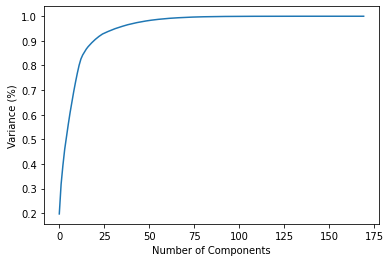

In [ ]:
# Visualize PCA for various numbers of principal components
pca = PCA()
pca.fit(X_train_tr)
pca_variances = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(pca_variances)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') # for each component
plt.show()

In [ ]:
# Apply PCA to the data
n_pc = np.where(pca_variances >= 0.99)[0][0] + 1
pca = PCA(n_components = n_pc).fit(X_train_tr)
X_train_pca = pca.transform(X_train_tr)
X_test_pca = pca.transform(X_test_tr)

In [ ]:
# Compare array shapes before and after PCA
print("X_train:", X_train_tr.shape, "-->", X_train_pca.shape)
print("Y_train:", Y_train_tr.shape)
print("X_test:", X_test_tr.shape, "-->", X_test_pca.shape)
print("Y_test:", Y_test_tr.shape)

X_train: (130531, 170) --> (130531, 60)
Y_train: (130531,)
X_test: (32649, 170) --> (32649, 60)
Y_test: (32649,)


In [ ]:
# Number of classes
n_classes = np.unique(Y_train_tr).size
n_classes

5

In [ ]:
model = LogisticRegression()
model.fit(X_train_pca, Y_train_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Make predictions
Y_train_pred = model.predict(X_train_pca)
Y_test_pred = model.predict(X_test_pca)

In [ ]:
# Confusion matrix for training set
pd.DataFrame(confusion_matrix(Y_train_pred, Y_train_tr))

,0,1,2,3,4
0,86881,0,0,0,0
1,0,9780,1,0,0
2,0,0,26596,0,0
3,0,0,0,6380,0
4,0,0,0,0,893


In [ ]:
# Confusion matrix for testing set
pd.DataFrame(confusion_matrix(Y_test_pred, Y_test_tr))

,0,1,2,3,4
0,21735,0,0,0,0
1,0,2508,0,0,0
2,0,0,6608,0,0
3,0,0,0,1554,0
4,0,0,0,0,244


In [ ]:
# Calculate metrics for training set
acc_train = accuracy_score(Y_train_tr, Y_train_pred)
prec_train = precision_score(Y_train_tr, Y_train_pred, average = None)
recall_train = recall_score(Y_train_tr, Y_train_pred, average = None)
f1_train = f1_score(Y_train_tr, Y_train_pred, average = None)

# Calculate metrics for testing set
acc_test = accuracy_score(Y_test_tr, Y_test_pred)
prec_test = precision_score(Y_test_tr, Y_test_pred, average = None)
recall_test = recall_score(Y_test_tr, Y_test_pred, average = None)
f1_test = f1_score(Y_test_tr, Y_test_pred, average = None)

In [ ]:
# Create dataframe
metrics_train = np.array([acc_train, \
                          prec_train[0], prec_train[1], prec_train[2], prec_train[3], prec_train[4], \
                          recall_train[0], recall_train[1], recall_train[2], recall_train[3], recall_train[4], \
                          f1_train[0], f1_train[1], f1_train[2], f1_train[3], f1_train[4]])

metrics_test = np.array([acc_test, \
                         prec_test[0], prec_test[1], prec_test[2], prec_test[3], prec_test[4], \
                         recall_test[0], recall_test[1], recall_test[2], recall_test[3], recall_test[4], \
                         f1_test[0], f1_test[1], f1_test[2], f1_test[3], f1_test[4]])

metrics = {"Training Set": metrics_train, "Testing Set": metrics_test}
metrics = pd.DataFrame(metrics)
metrics.index = ["Accuracy", \
                 "Precision (Class 0)", "Precision (Class 1)", "Precision (Class 2)", "Precision (Class 3)", "Precision (Class 4)", \
                 "Recall (Class 0)", "Recall (Class 1)", "Recall (Class 2)", "Recall (Class 3)", "Recall (Class 4)", \
                 "F1 Score (Class 0)", "F1 Score (Class 1)", "F1 Score (Class 2)", "F1 Score (Class 3)", "F1 Score (Class 4)"]

In [ ]:
# Display metrics
metrics

,Training Set,Testing Set
Accuracy,0.999992,1.0
Precision (Class 0),1.000000,1.0
Precision (Class 1),0.999898,1.0
Precision (Class 2),1.000000,1.0
Precision (Class 3),1.000000,1.0
Precision (Class 4),1.000000,1.0
Recall (Class 0),1.000000,1.0
Recall (Class 1),1.000000,1.0
Recall (Class 2),0.999962,1.0
Recall (Class 3),1.000000,1.0
